In [1]:
# orthoFinder parser
# generate the orphan gene from different level

# set up file path
import pandas as pd
from Bio.SeqFeature import SeqFeature, FeatureLocation
import glob
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import argparse
from pathlib import Path
from Bio import SeqIO
from Bio import SearchIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import json
species_file_name_table = 'file_list.csv'
orthogroup_path = 'Orthogroups.tsv'
peptide_file_dir = 'fasta_files'
orphan_table = 'orphan_info_WIP0717.csv'

# set up focal groups in list
focal_list = [
    "PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa",
    "PtremulaxPopulusalbaaltv2.1.primaryTrs.pep.fa",
    "PtremulaxPopulusalbav2.1p.primaryTrs.pep.fa",
    "Ptrichocarpa_444_v3.1.protein.fa",
    "PtrichocarpaStettler14_532_v1.1.protein.fa",
    "Ptrichocarpav4.1g.primaryTrs.pep.fa"
]
non_focal_sp = 'Acomosus_321_v3.protein.fa'
fpkm_file = 'neo_fpkm.csv'


# import packages and read in files

# read files
orphan_file_list = glob.glob('orphan*.fasta')
with open('subset_info.json', 'r') as f:
    subset_info = json.load(f)
# orthogroup = pd.read_csv(orthogroup_path, delimiter='\t')
species_csv = pd.read_csv(species_file_name_table)
fpkm_csv = pd.read_csv(fpkm_file)
orphan_csv = pd.read_csv(orphan_table)


def g2p(potri_gene_id: str) -> str:
    return potri_gene_id[:-4]


fpkm_csv.head(3)


FileNotFoundError: [Errno 2] No such file or directory: 'subset_info.json'

In [25]:
orphan_csv.columns  # 'Unnamed: 0', 'gene_id', 'reference', 'orphan_level', 'orthogroup',
#    'peptide_length', 'peptide_sequence', 'isoelectric_point',
potri_orphan_list = orphan_csv[orphan_csv.reference ==
                               'Ptrichocarpa_444_v3.1.protein.fa'].gene_id
orphan_csv.drop('Unnamed: 0', inplace=True, axis=1)
potri_orphan_csv = orphan_csv[orphan_csv.reference ==
                              'Ptrichocarpa_444_v3.1.protein.fa']
# 5074
# fpkm_csv.drop('Unnamed: 0', inplace=True, axis=1)
fpkm_csv.set_index('Unnamed: 0', inplace=True)


In [26]:
# do some exploration of the samples
# original way to segment data: http://forestry.fafu.edu.cn/db/SDX/expression_profile/expression.py?gene_name=Potri.001G011000
source_dict = json.load(open('trt_whole.json'))
trt_list = list(source_dict.keys())

trt_type = {
    "stress": ['SDX-drought', 'Leaf-', 'Root-', 'Stem-'],  # stress
    # tissue
    "tissue": ['ShootTip', 'LeafR', 'Phloem', 'PrimaryRoot', 'XylemFiberCell', 'SDXR', 'ThreeCell'],
    "transgenic": ['miR397', 'sGFP', 'PtrSND1-B1+sGFP']  # transgenic line
}
# unknown: "SDXRep1" ,"ThreeCell"
trt_samples = {
    "stress": [],  # stress
    "tissue": [],  # tissue
    "transgenic": []  # transgenic line
}
for trt_name, keywords in trt_type.items():
    count = 0
    for keyword in keywords:

        # print(len([trt for trt in trt_list if trt.startswith(keyword)]))
        trts = [trt for trt in trt_list if trt.startswith(keyword)]
        count += len(trts)
        trt_samples[trt_name].extend(trts)

    print(count)


92
21
30


In [50]:
import matplotlib
import matplotlib.pyplot as plt

## https://stackoverflow.com/questions/52806878/seaborn-clustermap-fixed-cell-size
def fixedWidthClusterMap(dataFrame, cellSizePixels=50):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth = matplotlib.rcParams['figure.subplot.right'] - \
        matplotlib.rcParams['figure.subplot.left']
    marginHeight = matplotlib.rcParams['figure.subplot.top'] - \
        matplotlib.rcParams['figure.subplot.bottom']
    Ny, Nx = dataFrame.shape
    figWidth = (Nx*cellSizePixels/dpi)/0.8/marginWidth
    figHeigh = (Ny*cellSizePixels/dpi)/0.8/marginHeight

    # do the actual plot
    grid = sns.clustermap(dataFrame, figsize=(figWidth, figHeigh),

                          #  standard_scale = 0,
                          z_score=0,
                          col_cluster=False,
                          cmap='cividis',
                          #  row_cluster = False,
                          #    xticklabels=1
                          )
    # calculate the size of the heatmap axes
    axWidth = (Nx*cellSizePixels)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels)/(figHeigh*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = grid.ax_heatmap.get_position()
    grid.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0,
                                  axWidth, axHeight])

    # resize dendrograms to match
    ax_row_orig_pos = grid.ax_row_dendrogram.get_position()
    grid.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0,
                                         ax_row_orig_pos.width, axHeight])
    ax_col_orig_pos = grid.ax_col_dendrogram.get_position()
    grid.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])
    return grid  # return ClusterGrid object


In [89]:
count = 0
count_list = []
des_list = []
num_list = []
subset_list = []
for subset in potri_orphan_csv.orphan_level.unique():
    
    
    subset_list.append(subset)
    current_list = list(
        potri_orphan_csv[potri_orphan_csv.orphan_level == subset].gene_id)
    current_list = [g2p(gene) for gene in current_list]
    potri_orphan_set_list.append(current_list)
    count_list.append(count)
    num_list.append(len(current_list))
    print(f"{count}  {subset}    {len(current_list)}")
    count+=1
pd.DataFrame({
    'count': count_list,
    'subset': subset_list,
    'num': num_list

}).to_csv(f"subset_ptri.csv", index=False)

0  ('Ptrichocarpa_444_v3.1.protein.fa',)    863
1  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    2329
2  ('PtremulaxPopulusalbaaltv2.1.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    34
3  ('PtremulaxPopulusalbav2.1p.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    33
4  ('Ptrichocarpa_444_v3.1.protein.fa', 'PtrichocarpaStettler14_532_v1.1.protein.fa')    82
5  ('Ptrichocarpa_444_v3.1.protein.fa', 'Ptrichocarpav4.1g.primaryTrs.pep.fa')    120
6  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'PtremulaxPopulusalbaaltv2.1.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    87
7  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'PtremulaxPopulusalbav2.1p.primaryTrs.pep.fa', 'Ptrichocarpa_444_v3.1.protein.fa')    77
8  ('PdeltoidesWV94_445_v2.1.protein_primaryTranscriptOnly.fa', 'Ptrichocarpa_444_v3.1.protein.fa', 'PtrichocarpaStettler14_532_v1.1.protein.fa')    96
9  ('PdeltoidesWV9

In [ ]:

# read all orphans and put to different part


subset_list = []
potri_orphan_set_list = []
problem = []
count = 0
for subset in potri_orphan_csv.orphan_level.unique():
    
    # print(subset)
    subset_list.append(subset)
    current_list = list(
        potri_orphan_csv[potri_orphan_csv.orphan_level == subset].gene_id)
    current_list = [g2p(gene) for gene in current_list]
    potri_orphan_set_list.append(current_list)
    

    focal_table = fpkm_csv[fpkm_csv.index.isin(current_list)]
    

    # expressing_orphan = expressing_orphan.loc[(
    # expressing_orphan != 0).any(axis=1)]

    # sns.clustermap(expressing_orphan,
    #                z_score = 0,
    #             #    standard_scale=0,
    #                figsize=(20, 20), cmap='RdBu_r')
    for trt_name, samples in trt_samples.items():
        current_table = focal_table[samples]
        current_table = current_table.loc[(current_table != 0).any(axis=1)]
        
        # plt.tight_layout()
        # grid = fixedWidthClusterMap(current_table, cellSizePixels=20)
        # plt.show()
        # grid.savefig(f"{subset}_{trt_name}_{len(current_list)}genes.png", bbox_inches="tight")
        # break
        try:
            sns.set(rc={'figure.figsize': (90, 8.27)})
            g = sns.clustermap(current_table,
                            #  standard_scale = 0,
                            z_score=0,
                            col_cluster=False,
                            cmap='cividis',
                            #  row_cluster = False,
                            xticklabels=1,
                            square=True,
                            )

            plt.tight_layout()
            g.fig.suptitle(f"{count} - {trt_name} - {len(current_list)}genes")
            plt.savefig(
                f"{count}_{trt_name}_{len(current_list)}genes.png", bbox_inches="tight")
        except:
            problem.append(f"{count}_{trt_name}_{len(current_list)}")
    count += 1

    # sns.clustermap(expressing_orphan,
    #             #    z_score = 0,
    #                standard_scale=0,
    #                col_cluster=False,
    #                figsize=(20, 20), cmap='cividis')
    # break
with open("sn_subset.txt", 'w') as f:
    for sn, subset in enumerate(subset_list):
        f.write(f"{sn} {subset}\n")
# about 384 second

In [50]:
expressing_orphan = fpkm_csv[fpkm_csv.gene_id.isin(potri_orphan_prot_list)]
# 3497
expressing_orphan = expressing_orphan.loc[(expressing_orphan != 0).any(axis=1)]
expressing_orphan = expressing_orphan.set_index('gene_id')


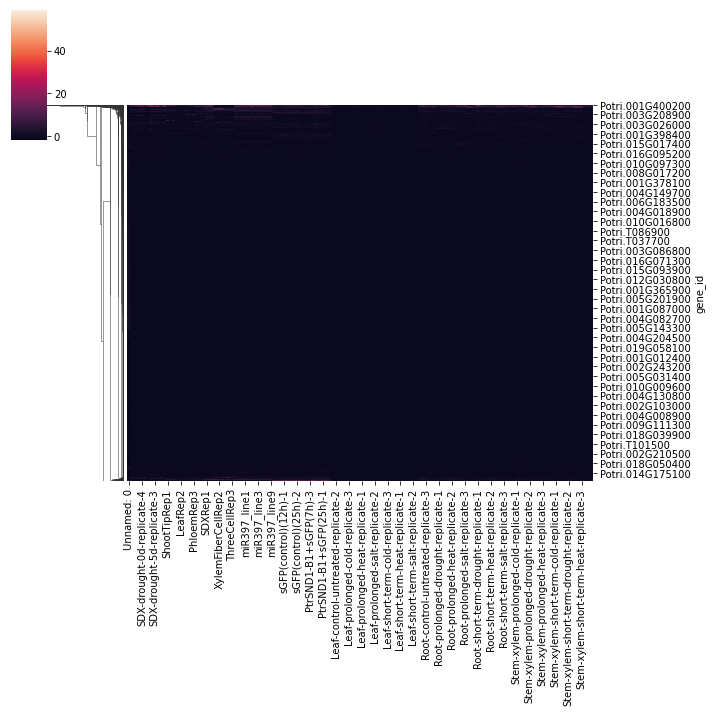

In [57]:
sns.clustermap(expressing_orphan, z_score=1,
               col_cluster=False, figsize=(10, 10))
# expressing_orphan.to_csv("potri_orphan_exp.csv")


In [6]:
# read fasta files
peptide_file_dir = Path.cwd() / Path(peptide_file_dir)
species_pep_dict = {}
print("reading fasta files")
for index, row in tqdm(species_csv.iterrows()):
    species = row['species_id']
    pep_seq_file = peptide_file_dir / row['file_name.fa']
    seq_dict = SeqIO.to_dict(SeqIO.parse(pep_seq_file, "fasta"))
    species_pep_dict[species] = seq_dict

orthogroup = orthogroup.set_index("Orthogroup")

# 108471


0it [00:00, ?it/s]

reading fasta files


65it [00:59,  1.10it/s]


In [3]:

# helper functions
def s2l(species_id):
    return species_csv.set_index('species_id').loc[species_id]['file_name.fa'][:-3]


In [4]:
# start parsing
orphan_dict = {}
subset_dict = {}
subset_sn = 0
count = 0
annotation_table_list = []


print("start parsing")
for L in tqdm(range(0, len(focal_list)+1)):
    for subset in itertools.combinations(focal_list, L):
        subset_sn += 1
        # skip the empty set
        if len(subset) == 0:
            continue
        # trim OG containing non focal species
        # prepare a total_filter that is defo not in the focal list
        total_filter = orthogroup[s2l(non_focal_sp)].isnull()
        for species_id in species_csv.set_index('species_id').index:
            # OG have focal sp not null
            if species_id in subset:
                total_filter = total_filter & orthogroup[s2l(
                    species_id)].notnull()
                continue
            # every not focal species should be mull
            species_filter = orthogroup[s2l(species_id)].isnull()
            total_filter = total_filter & species_filter

        current_table = orthogroup[total_filter]
        orphan_dict[subset] = current_table.dropna(axis=1)
        count += current_table.shape[0]
        # print(f"{list(subset)}: {current_table.shape[0]}")

        gene_list = []
        reference_list = []
        seq_record_list = []
        subset_str = ""
        # prepare annotation table and output fasta file
        for sp in subset:
            subset_str = subset_str + sp + "_"
            for orphan_list in [og.split(', ') for og in current_table[s2l(sp)]]:
                for orphan in orphan_list:
                    gene_list.append(orphan)
                    reference_list.append(sp)
                    seq_dict = species_pep_dict[sp]
                    seq_record_list.append(seq_dict[orphan])
        file_name = f"orphan_{subset_sn}_{len(subset)}_{len(gene_list)}.fasta"
        SeqIO.write(seq_record_list, file_name, "fasta")
        subset_dict[subset_sn] = subset

with open('subset_info.json', 'w') as fp:
    json.dump(subset_dict, fp)
print(count)


 14%|█▍        | 1/7 [00:00<00:00, 3435.14it/s]

start parsing


NameError: name 'orthogroup' is not defined

In [25]:
% % time

gene_list = []

reference_list = []
level_list = []
orthogroup_list = []
peptide_length_list = []
peptide_list = []
isoelectric_point_list = []
molecular_weight_list = []
aromaticity_list = []
instability_index_list = []
flexibility_list = []
secondary_structure_fraction_list = []

bio_embeddings_subcellular_location_list = []
bio_embeddings_membrane_soluble_list = []
bio_embeddings_disorder_list = []

for combination, current_table in tqdm(orphan_dict.items()):
    for sp in combination:
        for (orthogroup, orphan_list) in [(orthogroup, orphan_genes.split(', ')) for orthogroup, orphan_genes in current_table[s2l(sp)].iteritems()]:
            for orphan in orphan_list:
                gene_list.append(orphan)
                reference_list.append(sp)
                level_list.append(combination)
                orthogroup_list.append(orthogroup)
                # get peptide sequence
                pep_seq = species_pep_dict[sp][orphan]
                analysed_seq = ProteinAnalysis(str(pep_seq.seq).strip('*'))
                peptide_length_list.append(len(str(pep_seq.seq).strip('*')))
                peptide_list.append(pep_seq.seq)
                isoelectric_point_list.append(analysed_seq.isoelectric_point())
                molecular_weight_list.append(analysed_seq.molecular_weight())
                aromaticity_list.append(analysed_seq.aromaticity())
                instability_index_list.append(analysed_seq.instability_index())
                flexibility_list.append(analysed_seq.flexibility())
                secondary_structure_fraction_list.append(
                    analysed_seq.secondary_structure_fraction())
                # TODO: add bio_embeddings
                # bio_embeddings_subcellular_location_list.append(bio_embeddings_dict[sp][bio_embeddings_dict[species_4]['original_id'] == gene_id]['subcellular_location'].values)
                # bio_embeddings_membrane_soluble_list.append(bio_embeddings_dict[sp][bio_embeddings_dict[species_4]['original_id'] == gene_id]['membrane_or_soluble'].values)


big_table = pd.DataFrame.from_dict({
    "gene_id": gene_list,
    "reference": reference_list,
    "orphan_level": level_list,
    "orthogroup": orthogroup_list,
    "peptide_length": peptide_length_list,
    "peptide_sequence": peptide_list,
    "isoelectric_point": isoelectric_point_list,
    "molecular_weight": molecular_weight_list,
    # "CCTOP": cctop_list,
    "aromaticity": aromaticity_list,
    "instability_index": instability_index_list,
    "flexibility": flexibility_list,
    "secondary_structure_fraction([Helix, Turn, Sheet])": secondary_structure_fraction_list,
    # "bio_embeddings_subcellular_location": bio_embeddings_subcellular_location_list,
    # "bio_embeddings_membrane_soluble": bio_embeddings_membrane_soluble_list
})
big_table.to_csv("orphan_info_WIP0717.csv")


100%|██████████| 63/63 [00:11<00:00,  5.61it/s]


CPU times: user 13.2 s, sys: 126 ms, total: 13.3 s
Wall time: 13.4 s


In [ ]:
# species_pep_dict['717m'].keys()
examine_list = []
for sn, gene in enumerate(gene_list):

    sp = reference_list[sn]
    seq_dict = species_pep_dict[sp]

    # print(seq_dict[gene])
    examine_list.append(seq_dict[gene])


In [ ]:
from Bio import SeqIO
SeqIO.write(examine_list[0:4000], "orphans_for_blast_1.fasta", "fasta")
SeqIO.write(examine_list[4000:], "orphans_for_blast_2.fasta", "fasta")


3305